In [17]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
import matplotlib as mpl
import matplotlib.pyplot as plt
from IPython.display import display

In [94]:
pd.set_option('display.width', 300)
pd.set_option('display.max_columns', 300)

data = pd.read_csv('car.data', header = None)
display(data.head())
n_columns = len(data.columns)
columns = ['buy', 'maintain', 'doors', 'persons', 'boot', 'saftey', 'accept']
new_columns = dict(list(zip(np.arange(n_columns), columns)))    #0-6进行命名
data.rename(columns = new_columns, inplace = True)
display(new_columns)
data.head()

,0,1,2,3,4,5,6
0,vhigh,vhigh,2,2,small,low,unacc
1,vhigh,vhigh,2,2,small,med,unacc
2,vhigh,vhigh,2,2,small,high,unacc
3,vhigh,vhigh,2,2,med,low,unacc
4,vhigh,vhigh,2,2,med,med,unacc


{0: 'buy',
 1: 'maintain',
 2: 'doors',
 3: 'persons',
 4: 'boot',
 5: 'saftey',
 6: 'accept'}

,buy,maintain,doors,persons,boot,saftey,accept
0,vhigh,vhigh,2,2,small,low,unacc
1,vhigh,vhigh,2,2,small,med,unacc
2,vhigh,vhigh,2,2,small,high,unacc
3,vhigh,vhigh,2,2,med,low,unacc
4,vhigh,vhigh,2,2,med,med,unacc


## one-hot编码

In [95]:
# one-hot编码
x = pd.DataFrame()
display(x.shape)
for col in columns[:-1]:
    t = pd.get_dummies(data[col])    #对当前col进行one-hot
    t = t.rename(columns=lambda x: col+'_'+str(x))    #重命名每一类别
    x = pd.concat((x, t), axis=1)    #合并
    
y = pd.Categorical(data['accept']).codes    #对'accept'列元素进行汇总，用数字代替

display(x.head())
y

(0, 0)

,buy_high,buy_low,buy_med,buy_vhigh,maintain_high,maintain_low,maintain_med,maintain_vhigh,doors_2,doors_3,doors_4,doors_5more,persons_2,persons_4,persons_more,boot_big,boot_med,boot_small,saftey_high,saftey_low,saftey_med
0,0,0,0,1,0,0,0,1,1,0,0,0,1,0,0,0,0,1,0,1,0
1,0,0,0,1,0,0,0,1,1,0,0,0,1,0,0,0,0,1,0,0,1
2,0,0,0,1,0,0,0,1,1,0,0,0,1,0,0,0,0,1,1,0,0
3,0,0,0,1,0,0,0,1,1,0,0,0,1,0,0,0,1,0,0,1,0
4,0,0,0,1,0,0,0,1,1,0,0,0,1,0,0,0,1,0,0,0,1


array([2, 2, 2, ..., 2, 1, 3], dtype=int8)

In [6]:
from sklearn.preprocessing import OneHotEncoder

In [23]:
ohe = OneHotEncoder(sparse = False)
x = [[1, 2, 1],
     [1, 3, 0],
     [4, 0, 2],
     [0, 2, 2]]
x_onehot = ohe.fit_transform(x)
display(x_onehot)

array([[0., 1., 0., 0., 1., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0., 1., 1., 0., 0.],
       [0., 0., 1., 1., 0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 1., 0., 0., 0., 1.]])

## 拟合曲线

In [96]:
x, x_test, y, y_test =  train_test_split(x, y, test_size = 0.3)   #分割训练/测试集
#使用交叉验证进行对数回归，惩罚项由lg(10^-3)~lg(10^4)共8个量级, 10折交叉
clf_lr = LogisticRegressionCV(Cs = np.logspace(-3, 4, 8), cv = 10)
clf_lr.fit(x, y)

clf_rf = RandomForestClassifier(n_estimators = 50, max_depth = 7)    #随机森林
clf_rf.fit(x, y)

y_hat_lr = clf_lr.predict(x)
y_hat_rf = clf_rf.predict(x)
print('Logistic回归训练集精度：', metrics.accuracy_score(y, y_hat_lr))    #返回精度(1-错误率)
print('随机森林回归训练集精度：', metrics.accuracy_score(y, y_hat_rf))

print("=====================")

y_test_hat_lr = clf_lr.predict(x_test)
y_test_hat_rf = clf_rf.predict(x_test)
print('Logistic回归测试集精度：', metrics.accuracy_score(y_test, y_test_hat_lr))
print('随机森林回归测试集精度：', metrics.accuracy_score(y_test, y_test_hat_rf))

n_class = len(np.unique(y))
n_class

Logistic回归训练集精度： 0.8974358974358975
随机森林回归训练集精度： 0.9553349875930521
Logistic回归测试集精度： 0.9152215799614644
随机森林回归测试集精度： 0.9344894026974951


4

In [97]:
y_test_one_hot = label_binarize(y_test, classes = np.arange(n_class))    #将测试集进行one-hot编码

y_test_one_hot_hat_lr = clf_lr.predict_proba(x_test)
'''返回的是一个n行k列的数组，第i行第j列上的数值是模型预测第i个预测样本为某个标签的概率，并且每一行的概率和为1'''
display(y_test_one_hot_hat_lr)

y_test_one_hot_hat_rf = clf_rf.predict_proba(x_test)
display(y_test_one_hot_hat_rf)

fpr_lr, tpr_lr, _ = metrics.roc_curve(y_test_one_hot.ravel(), y_test_one_hot_hat_lr.ravel())
print('Logistc Regression Micro AUC:\t', metrics.auc(fpr_lr, tpr_lr))

fpr_rf, tpr_rf, _ = metrics.roc_curve(y_test_one_hot.ravel(), y_test_one_hot_hat_rf.ravel())
print('Random Forest Micro AUC:\t', metrics.auc(fpr_rf, tpr_rf))

array([[5.62832127e-02, 3.59141054e-02, 9.07755312e-01, 4.73702096e-05],
       [2.59187433e-01, 2.93718908e-02, 7.11440672e-01, 3.53401763e-09],
       [2.62321470e-01, 3.43777155e-02, 7.03264588e-01, 3.62269553e-05],
       ...,
       [4.95582313e-01, 3.25482693e-02, 3.97982506e-04, 4.71471435e-01],
       [3.26763851e-02, 3.80331834e-02, 9.29290417e-01, 1.44029125e-08],
       [4.92728993e-02, 3.53714241e-02, 9.15355630e-01, 4.63882543e-08]])

array([[0.05332756, 0.        , 0.94667244, 0.        ],
       [0.19479174, 0.0178013 , 0.78343049, 0.00397647],
       [0.25457498, 0.00148148, 0.69975825, 0.04418528],
       ...,
       [0.48433796, 0.0678586 , 0.10771214, 0.3400913 ],
       [0.01614516, 0.        , 0.98385484, 0.        ],
       [0.03303922, 0.00235294, 0.96460784, 0.        ]])

Logistc Regression Micro AUC:	 0.9855101518037133
Random Forest Micro AUC:	 0.9942468781053432


Logistics Regression
Micro AUC:	 0.9855101518037133
Micro AUC(System):	 0.9855101518037133
Macro AUC:	 0.9698665604361705
Random Forest
Micro AUC:	 0.9942468781053432
Micro AUC(System):	 0.9942468781053432
Macro AUC:	 0.9918299876740564


/Users/lee_excited/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


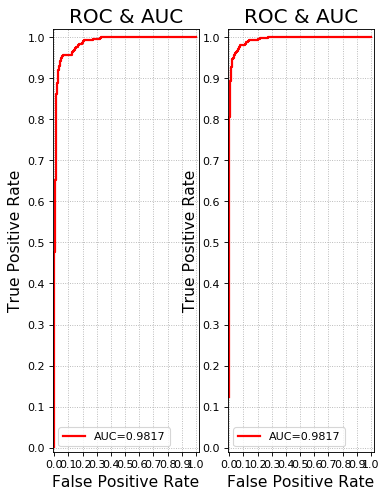

In [99]:
#ROC
def print_AUC(clf, y_test, x_test):
    global fpr
    global tpr
    y_test_one_hot = label_binarize(y_test, classes = np.arange(n_class))    #利用二值化函数将y_test进行one-hot编码
    y_test_one_hot_hat = clf.predict_proba(x_test)    # 返回属于各个标签概率的预测值
    fpr, tpr, _ = metrics.roc_curve(y_test_one_hot.ravel(), y_test_one_hot_hat.ravel())    #ROC值
    print('Micro AUC:\t', metrics.auc(fpr, tpr))
    auc = metrics.roc_auc_score(y_test_one_hot, y_test_one_hot_hat, average = 'micro')
    print('Micro AUC(System):\t', auc)
    auc = metrics.roc_auc_score(y_test_one_hot, y_test_one_hot_hat, average = 'macro')
    print('Macro AUC:\t', auc)


plt.figure(figsize = (8, 7), dpi = 80, facecolor = 'w')
fpr, tpr = 0, 0
if n_class > 2:
    print("Logistics Regression")
    print_AUC(clf_lr, y_test, x_test)
    plt.subplot(1, 3, 1)
    plt.plot(fpr, tpr, 'r-', lw = 2, label = 'AUC=%.4f' % auc)
    plt.legend(loc = 'best')
    plt.xlim((-0.01, 1.02))
    plt.ylim((-0.01, 1.02))
    plt.xticks(np.arange(0, 1.1, 0.1))
    plt.yticks(np.arange(0, 1.1, 0.1))
    plt.xlabel('False Positive Rate', fontsize = 14)
    plt.ylabel('True Positive Rate', fontsize = 14)
    plt.grid(b=True, ls=':')
    plt.title('ROC & AUC', fontsize=18)
    
    print("============")
    print("Random Forest")
    print_AUC(clf_rf, y_test, x_test)
    plt.subplot(1, 3, 2)
    plt.plot(fpr, tpr, 'r-', lw = 2, label = 'AUC=%.4f' % auc)
    plt.legend(loc = 'best')
    plt.xlim((-0.01, 1.02))
    plt.ylim((-0.01, 1.02))
    plt.xticks(np.arange(0, 1.1, 0.1))
    plt.yticks(np.arange(0, 1.1, 0.1))
    plt.xlabel('False Positive Rate', fontsize = 14)
    plt.ylabel('True Positive Rate', fontsize = 14)
    plt.grid(b=True, ls=':')
    plt.title('ROC & AUC', fontsize=18)
    
    
else:
    fpr, tpr, _ = metrics.roc_curve(y_test.ravel(), y_test_hat.ravel())
    print('AUC:\t', metrics.auc(fpr, tpr))
    auc = metrics.roc_auc_score(y_test, y_test_hat)
    print('AUC(System):\t', auc)
    
plt.show()